In [1]:
# 1단계 : 최신 뉴스 검색 필요한건지 파악
# 2단계 -1) 뉴스 검색했다면 바로 답변
# 2단계 -2) 뉴스 검색 아니라면 아는 내용인지 판단
# 3단계 -1) 아는 내용이면 바로 답변
# 3단계 -2) 모르는 내용이면 검색후 답변

# 해야할 것
# 1. 아는 내용인지 모르는내용인지 판단하는 로직 추가
# 2. 뉴스 전처리 코드 추가
# 3. 뉴스 검색 이후 답변 추가
# 4. 답변하기 추가

In [2]:
from utils.util import set_env
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from modules.rss import RSSGetter
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from ml_collections import ConfigDict
from datetime import datetime
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from utils.util import trace_function, google_search_scrape, extract_content

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
default_system_message = "당신의 이름은 '미네르바'이고 카카오톡에서 활동하는 챗봇입니다. 'ccw'님이 관리하고 있는 챗봇입니다. 당신은 사용자의 질문과 요청에 친절하게 응답합니다. 가능한 핵심적인 내용만을 전달하세요.\n"

In [5]:
prompt_config = ConfigDict()
prompt_config.generate_search_info = f"""다음 사용자 요청문을 기반으로 웹에서 자료 검색을 하려고한다.

지침:
1. 오늘 날짜를 참고해서 검색어를 생성하라.
2. 검색어는 반드시 한국어로 작성한다.
3. 오늘 날짜 : {datetime.now().strftime("%Y-%m-%d")}

사용자 요청문: 
{{query}}

검색어:"""

prompt_config.answer_with_context = """[참고내용]을 참고해서 [사용자 요청문]에 대한 답변을 생성하세요.

[사용자 요청문]: 
{{query}}

[참고내용]: 
{context}

답변 : """

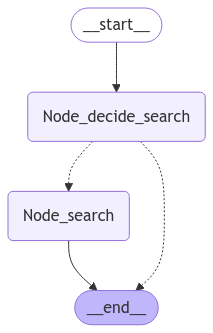

In [6]:
ShortTermMemory = MemorySaver()
llm = ChatOpenAI(model="gpt-4o")

class State(MessagesState):
    is_search: str

@trace_function(enable_print=False, only_node=True)
def Node_search(state: State):
    query = state['messages'][-1].content # TODO humanmessage 인지 체크필요
    prompt = prompt_config.generate_search_info.format(query=query)
    search_info = llm.invoke(prompt).content
    results = google_search_scrape(search_info, num_results=3)
    
    # TODO 결과없을때 처리필요
    context = ''
    suffix = ''
    for idx, result in enumerate(results):
        link = result.get("link")
        desc, detailed_content = extract_content(link)
        context += f"제목 : {result.get('title')}\n링크 : {link}\n설명 : {desc}\n내용 : {detailed_content}\n\n"    
        suffix += f"""
📌 참고내용 [{idx+1}]
제목 : {result.get('title')}
링크 : {link}
설명 : {desc}
"""
    prompt = prompt_config.answer_with_context.format(context=context, query=query)
    answer = llm.invoke(prompt).content + "\n" + suffix
    return {"messages": [AIMessage(content=answer)]}

def decide_search(state: State):
    if "YES" in state["is_search"]:
        return "Node_search"
    else:
        return END

@trace_function(enable_print=False, only_node=True)
def Node_decide_search(state: State):
    system_message = "현재 사용자 요청문이 뉴스 검색이 필요한지 판단하세요. 답변은 무조건 YES 또는 NO로 출력하세요."
    return {"is_search": [llm.invoke([SystemMessage(content=system_message)] + state["messages"])][0].content.upper()}

builder = StateGraph(State)
builder.add_node("Node_decide_search", Node_decide_search)
builder.add_node("Node_search", Node_search)
builder.add_edge(START, "Node_decide_search")
builder.add_conditional_edges("Node_decide_search", decide_search)
builder.add_edge("Node_search", END)
graph = builder.compile(checkpointer=ShortTermMemory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": "initial_chat",
                           "user_id": "changwoo2"}}

graph.invoke({"messages":"최근 테슬라 주가에 대해서 알려줘"}, config=config)

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  7.58it/s]


{'messages': [HumanMessage(content='최근 테슬라 주가에 대해서 알려줘', additional_kwargs={}, response_metadata={}, id='f1efc167-1ec2-4d74-9491-69ad580a3fa2'),
  AIMessage(content='2025년 1월 3일의 금융시장 동향에 따르면, 미국 증시는 주요 지수들이 소폭 하락하며 5거래일 연속 하락세를 보였습니다. S&P500과 나스닥 100 지수는 각각 0.2% 하락했으며, 이는 시가총액이 1조 달러 이상 감소한 결과를 가져왔습니다. 테슬라는 2024년 판매량이 예상치에 미치지 못하면서 주가가 한때 7% 이상 급락했습니다. 또한, 미국의 주간 신규 실업수당 청구건수는 21만1,000건으로 8개월래 최저치를 기록하며 노동시장의 견조함을 시사했습니다. 유럽 경제에 대한 우려로 유로화와 파운드화는 각각 2년 및 8개월 여 만에 최저치를 기록했습니다. 달러는 강세를 보이며 블룸버그 달러 인덱스가 0.3% 넘게 상승했습니다.\n📌 참고내용 [1]\n제목 : 2025년 1월 3일 금융시장 동향\n링크 : https://kbthink.com/main/economy/trend/daily-market-trend/2025/daily-market-trend-2025-01-03.html\n설명 : 지난 밤 미국 증시 주요 지수들은 소폭 하락 마감. 주요 지수들이 5거래일 연속 하락하면서 시가총액이 1조 달러 이상 감소. SP500과 나스닥 100 지수는 모두 0.2% 하락 \n\n📌 참고내용 [2]\n제목 : TESLA INC (TSLA) 과거 가격 데이터\n링크 : https://kr.investing.com/equities/tesla-motors-historical-data\n설명 : \n\n📌 참고내용 [3]\n제목 : [투자노트] “주가 꺾인 테슬라 사도 될까”… 걱정되면 1월 말 ...\n링크 : https://www.chosun.com/economy/money/20

In [8]:
msg = '2025년 1월 3일의 금융시장 동향에 따르면, 미국 증시는 주요 지수들이 소폭 하락하며 5거래일 연속 하락세를 보였습니다. S&P500과 나스닥 100 지수는 각각 0.2% 하락했으며, 이는 시가총액이 1조 달러 이상 감소한 결과를 가져왔습니다. 테슬라는 2024년 판매량이 예상치에 미치지 못하면서 주가가 한때 7% 이상 급락했습니다. 또한, 미국의 주간 신규 실업수당 청구건수는 21만1,000건으로 8개월래 최저치를 기록하며 노동시장의 견조함을 시사했습니다. 유럽 경제에 대한 우려로 유로화와 파운드화는 각각 2년 및 8개월 여 만에 최저치를 기록했습니다. 달러는 강세를 보이며 블룸버그 달러 인덱스가 0.3% 넘게 상승했습니다.\n📌 참고내용 [1]\n제목 : 2025년 1월 3일 금융시장 동향\n링크 : https://kbthink.com/main/economy/trend/daily-market-trend/2025/daily-market-trend-2025-01-03.html\n설명 : 지난 밤 미국 증시 주요 지수들은 소폭 하락 마감. 주요 지수들이 5거래일 연속 하락하면서 시가총액이 1조 달러 이상 감소. SP500과 나스닥 100 지수는 모두 0.2% 하락 \n\n📌 참고내용 [2]\n제목 : TESLA INC (TSLA) 과거 가격 데이터\n링크 : https://kr.investing.com/equities/tesla-motors-historical-data\n설명 : \n\n📌 참고내용 [3]\n제목 : [투자노트] “주가 꺾인 테슬라 사도 될까”… 걱정되면 1월 말 ...\n링크 : https://www.chosun.com/economy/money/2025/01/03/SUFU4TY7SQD5MJZDTEEM2FXLAI/\n설명 : 투자노트 주가 꺾인 테슬라 사도 될까 걱정되면 1월 말까지 기다려야 최근 5거래일간 주가 약 20% 하락 연간 인도량 전년比 감소하자 주가 약세 단기 조정일 수 있어 30일 실적발표 확인 미국 대표 전기차 업체 테슬라 주가가 지난주부터 지지부진한 모습이다. 간밤 테슬라'

In [9]:
print(msg)

2025년 1월 3일의 금융시장 동향에 따르면, 미국 증시는 주요 지수들이 소폭 하락하며 5거래일 연속 하락세를 보였습니다. S&P500과 나스닥 100 지수는 각각 0.2% 하락했으며, 이는 시가총액이 1조 달러 이상 감소한 결과를 가져왔습니다. 테슬라는 2024년 판매량이 예상치에 미치지 못하면서 주가가 한때 7% 이상 급락했습니다. 또한, 미국의 주간 신규 실업수당 청구건수는 21만1,000건으로 8개월래 최저치를 기록하며 노동시장의 견조함을 시사했습니다. 유럽 경제에 대한 우려로 유로화와 파운드화는 각각 2년 및 8개월 여 만에 최저치를 기록했습니다. 달러는 강세를 보이며 블룸버그 달러 인덱스가 0.3% 넘게 상승했습니다.
📌 참고내용 [1]
제목 : 2025년 1월 3일 금융시장 동향
링크 : https://kbthink.com/main/economy/trend/daily-market-trend/2025/daily-market-trend-2025-01-03.html
설명 : 지난 밤 미국 증시 주요 지수들은 소폭 하락 마감. 주요 지수들이 5거래일 연속 하락하면서 시가총액이 1조 달러 이상 감소. SP500과 나스닥 100 지수는 모두 0.2% 하락 

📌 참고내용 [2]
제목 : TESLA INC (TSLA) 과거 가격 데이터
링크 : https://kr.investing.com/equities/tesla-motors-historical-data
설명 : 

📌 참고내용 [3]
제목 : [투자노트] “주가 꺾인 테슬라 사도 될까”… 걱정되면 1월 말 ...
링크 : https://www.chosun.com/economy/money/2025/01/03/SUFU4TY7SQD5MJZDTEEM2FXLAI/
설명 : 투자노트 주가 꺾인 테슬라 사도 될까 걱정되면 1월 말까지 기다려야 최근 5거래일간 주가 약 20% 하락 연간 인도량 전년比 감소하자 주가 약세 단기 조정일 수 있어 30일 실적발표 확인 미국 대표 전기차 업체 테슬라 주가가 지난주부터 지지부진한